In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import xesmf as xe

In [2]:
def regrid_mask(ds, variable, reuse_weights=False):
    """
    Function to regrid onto coarser ERA5 grid (0.25-degree).

    Args:
        ds (xarray dataset): file.
        variable (str): variable.
        reuse_weights (boolean): Whether to use precomputed weights to speed up calculation.
                                 Defaults to ``False``.
    Returns:
        Regridded mask file for use with machine learning model.
    """
    ds_out = xe.util.grid_2d(lon0_b=0-0.5,   lon1_b=360-0.5, d_lon=1., 
                             lat0_b=-90-0.5, lat1_b=91,      d_lat=1.)

    regridder = xe.Regridder(ds, ds_out, method='nearest_s2d', reuse_weights=reuse_weights)

    return regridder(ds[variable])

In [3]:
era5_lsm = xr.open_dataset(
    '/glade/scratch/molina/lsm_1279l4_0.1x0.1.grb_v4_unpack.nc') # land sea mask
era5_lsm = regrid_mask(
    era5_lsm.isel(time=0), 'lsm', reuse_weights=False) # regrid lsm

In [4]:
# lsm is zero where there is no land
era5_lsm = xr.where(era5_lsm > 0., 1., 0.)

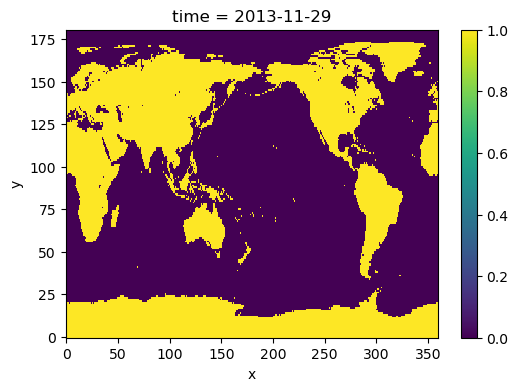

In [5]:
# converted to 1-degree global viz
era5_lsm.plot.pcolormesh('x','y',vmin=0,vmax=1,figsize=(6,4)); plt.show()

In [6]:
ds_era5_lsm = xr.Dataset(
    data_vars=dict(
        lsm=(["x", "y"], era5_lsm.transpose('x','y').values),
    ),
    coords=dict(
        x=(["x"], era5_lsm.lon[0,:].values),
        y=(["y"], era5_lsm.lat[:,0].values),
    ),
    attrs=dict(description="ML coords."),
)

In [7]:
ds_era5_lsm

<xarray.Dataset>
Dimensions:  (x: 360, y: 181)
Coordinates:
  * x        (x) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * y        (y) float64 -90.0 -89.0 -88.0 -87.0 -86.0 ... 87.0 88.0 89.0 90.0
Data variables:
    lsm      (x, y) float64 1.0 1.0 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
Attributes:
    description:  ML coords.

In [8]:
# save for future
ds_era5_lsm.to_netcdf('/glade/scratch/molina/s2s/CESM2_OBS/era5_lsmask.nc')